In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [4]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import datetime

from load_and_process_data import process_data
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### 1. Import all data into single pandas dataframe:

In [ ]:
# In jupyter import files like:
#datafolder = join(os.getcwd()[:os.getcwd().index('Code')]) + 'Data/ashrae-energy-prediction/'
#pd_all = process_data(datafolder)

In [ ]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

In [ ]:
pd_all

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter,meter_reading
0,0,0,Education,7432,2008.0,5.0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.70,0.0,0.0,0,0.000
1,0,0,Education,7432,2008.0,5.0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.20,70.0,1.5,0,0.000
2,0,0,Education,7432,2008.0,5.0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.20,0.0,0.0,0,0.000
3,0,0,Education,7432,2008.0,5.0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.10,0.0,0.0,0,0.000
4,0,0,Education,7432,2008.0,5.0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.00,250.0,2.6,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20125600,15,1448,Office,92271,2001.0,4.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,0,3.400
20125601,15,1448,Office,92271,2001.0,4.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,0,2.700
20125602,15,1448,Office,92271,2001.0,4.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,0,3.050
20125603,15,1448,Office,92271,2001.0,4.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,0,3.125


In [ ]:
dictionary_meter = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
pd_all = pd_all.replace({'meter':dictionary_meter})
pd_all = pd.get_dummies(pd_all, columns = ['meter','primary_use'], prefix=['',''],prefix_sep=['',''])

In [ ]:
#list(pd_all)

In [ ]:
bins = [0,1940, 1980, np.inf] 
names = ['1900-1940', '1940-1980', '1980-today']

pd_all['year_range'] = pd.cut(pd_all['year_built'], bins, labels=names)

In [ ]:
pd_all = pd_all.drop(columns = 'year_built')

In [ ]:
len(list(pd_all))

34

In [ ]:
pd_all = pd.get_dummies(pd_all, columns = ['year_range'],prefix=[''],prefix_sep=[''])

In [ ]:
len(list(pd_all))

36

In [ ]:
#list(pd_all)

In [ ]:
pd_all = pd_all.drop(columns = 'site_id')

In [ ]:
#pd_all.describe().transpose()

In [ ]:
normalizer = preprocessing.Normalization()

In [ ]:
merged_train = pd_all.loc[(pd_all["electricity"]==1)]

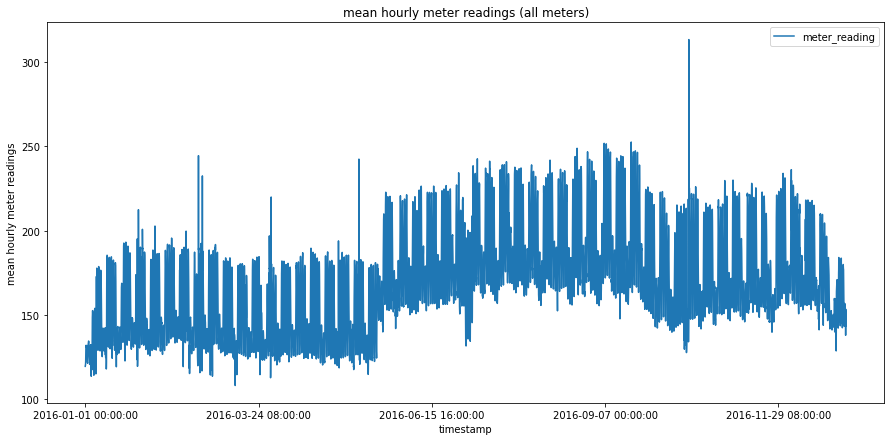

In [ ]:
merged_train.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

### 2. Let's try linear regression on a bit smaller data to get initial understanding of the tensorflow structure.

I will use only the features I strongly believe contribute to learning. Also I won't try one-hot encoding for now but I will try to do numeric encoding for all the features.

In [ ]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

In [ ]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_initial = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_init_elect = pd_initial.loc[(pd_initial["meter"]==0)]

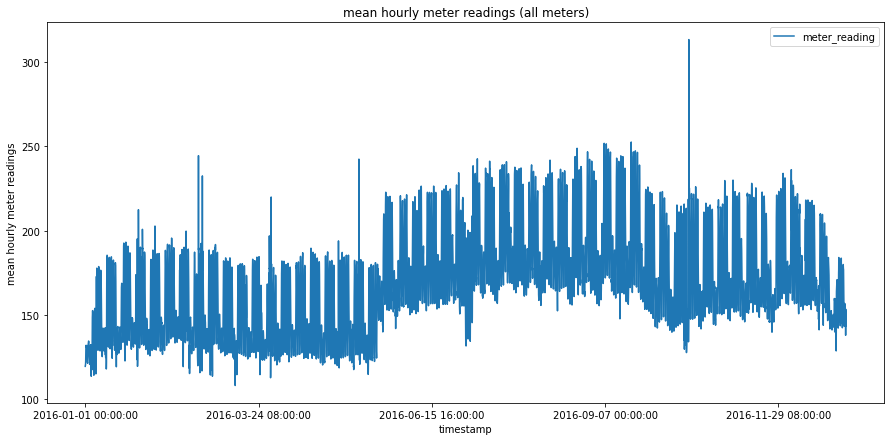

In [ ]:
pd_init_elect.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [ ]:
pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 2, 1)

0            True
1            True
2            True
3            True
4            True
            ...  
20125600    False
20125601    False
20125602    False
20125603    False
20125604    False
Name: timestamp, Length: 12017408, dtype: bool

In [ ]:
pd_init_elect_fm = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 1, 2)]

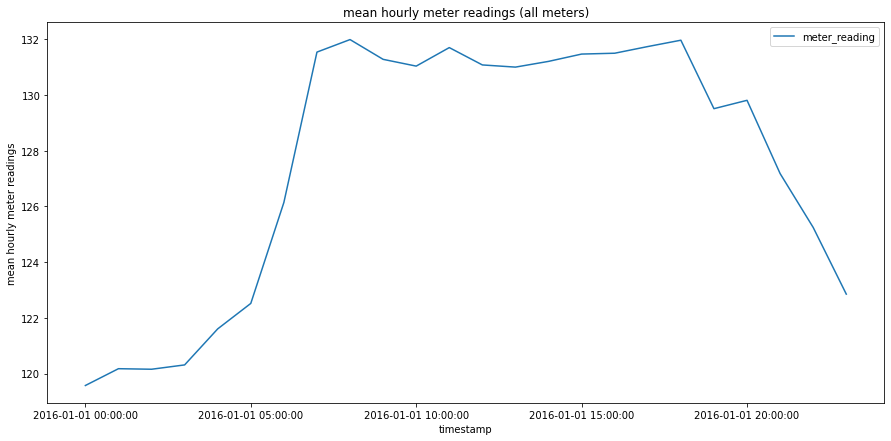

In [ ]:
pd_init_elect_fm.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

#### Split time into month, weekday, hour:

In [ ]:
#### Split time into month, weekday, hour and am/pm:
pd_init_elect['month'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.month
pd_init_elect['weekday'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.weekday
pd_init_elect['hour'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.hour
#pd_init_elect['hour'] = pd_initial.loc[(pd.to_datetime(pd_init_elect["timestamp"]).dt.hour%12)]
#pd_init_elect['am'] = pd_initial.loc[(pd.to_datetime(pd_init_elect["timestamp"]).dt.hour<=12)]
                                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### Split all data into training and testing data:

In [ ]:
pd_train = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) > datetime.datetime(2016, 11, 30)]

#### Let's prepare dataset for tensorflow:

In [ ]:
# Split training data:
#target = pd_train.pop('meter_reading')
timestamp_train = pd_train.pop('timestamp')
meter_train = pd_train.pop('meter')

In [ ]:
# Convert primary_use into category:
pd_train['primary_use'] = pd_train.primary_use.astype('category').cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#traindataset = tf.data.Dataset.from_tensor_slices((pd_train.values, target.values))

traindataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(pd_train.values, tf.float32),
            tf.cast(target.values, tf.int32)
        )
    )
)

In [ ]:
pd_train_subset = pd_train[['meter_reading','primary_use','square_feet','year_built','air_temperature','month','weekday','hour']]

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('meter_reading')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
trainingdata_subset = df_to_dataset(pd_train_subset)

In [ ]:
## New try on the dataset:
pd_train_subset = pd_train[['meter_reading','primary_use','square_feet','year_built','air_temperature','month','weekday','hour']]
train_features = pd_train_subset.copy()

train_labels = train_features.pop('meter_reading')

In [ ]:
## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[3.4077079e+00 9.2692023e+04 1.9689436e+03 1.6850967e+01 6.0518188e+00
 3.0004306e+00 1.1508832e+01]


In [ ]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

In [ ]:
linear_regression_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 23
Trainable params: 8
Non-trainable params: 15
_________________________________________________________________


In [ ]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
optim = keras.optimizers.Adam(lr=0.1)

linear_regression_model.compile(optimizer=optim, loss=loss)

In [ ]:
history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=10,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/10
 37409/274953 [===>..........................] - ETA: 5:51 - loss: 115616.3926

KeyboardInterrupt: ignored

#### Let's make feature encoding:

In [ ]:
primary_use = tf.feature_column.numeric_column('primary_use')
square_feet = tf.feature_column.numeric_column('square_feet')
year_built = tf.feature_column.numeric_column('year_built')
air_temperature = tf.feature_column.numeric_column('air_temperature')
month = tf.feature_column.numeric_column('month')
weekday = tf.feature_column.numeric_column('weekday')
hour = tf.feature_column.numeric_column('hour')

feature_layer = tf.keras.layers.DenseFeatures([primary_use,square_feet,year_built,air_temperature,month,weekday,hour])

#### Let's make a linear_regression model:

In [ ]:
def linear_regression_model(learning_rate, feature_layer):
  model = tf.keras.models.Sequential()
  # add layer that is doing feature encoding:
  model.add(feature_layer)
  # add a fully-connected linear layer for linear regression:
  model.add(tf.keras.layers.Dense(units = 1)) # units is 1 because we are predicting just one number: meter_reading

  # Compile a model and define loss function and metric:
  model.compile(optimizer = keras.optimizers.Adam(lr = learning_rate), loss = tf.keras.losses.MeanSquaredError(), metrics = [tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 256

model = linear_regression_model(learning_rate, feature_layer)
model.fit(traindataset_subset.batch(batch_size), epochs=epochs, shuffle=True)

Epoch 1/10


ValueError: ignored

### 3. Let's try linear regression with smaller number of features on just one building:

In [5]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

#### Looking at the plots I found that building 200 had a reasonable graph. I will try to fit data for this building:

In [156]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_initial = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_init_elect = pd_initial.loc[(pd_initial["meter"]==0)]
pd_init_elect = pd_init_elect.loc[(pd_initial["building_id"]==200)]

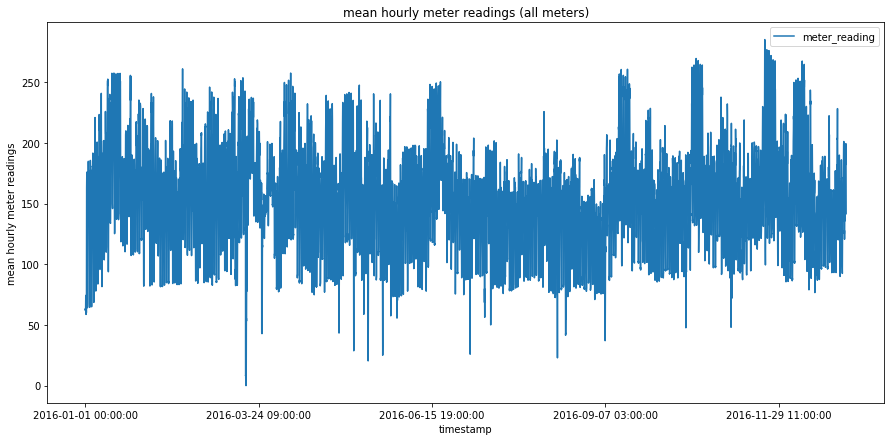

In [157]:
pd_init_elect.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [158]:
#### Split time into month, weekday, hour and am/pm:
pd_init_elect['month'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.month
pd_init_elect['weekday'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.weekday
pd_init_elect['hour'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.hour

In [159]:
pd_train = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) > datetime.datetime(2016, 11, 30)]

In [160]:
timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

pd_train.pop('meter')
pd_test.pop('meter')

2457489    0
2457492    0
2457495    0
2457498    0
2457501    0
          ..
2459772    0
2459775    0
2459778    0
2459781    0
2459784    0
Name: meter, Length: 766, dtype: int64

In [161]:
## New try on the dataset:
features = ['meter_reading','square_feet','year_built','air_temperature','month','weekday','hour']
pd_train_subset = pd_train[features]
train_features = pd_train_subset.copy()
pd_test_subset = pd_test[features]
test_features = pd_test_subset.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

In [162]:
#train_labels_norm =(train_labels - np.mean(train_labels))/np.std(train_labels)
#test_labels_norm = (test_labels - np.mean(train_labels))/np.std(train_labels) #normalize by train mean and std

In [193]:
## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[1.4309300e+05 1.9640000e+03 2.5951443e+01 6.0065947e+00 3.0008709e+00
 1.1501804e+01]


In [194]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

In [195]:
linear_regression_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_13 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [196]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=1) #learning is super dependent on learning rate, for 0.01 it didn't learn well
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [197]:
history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=20,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/20
201/201 [==============================] - 1s 2ms/step - loss: 13427.4865 - val_loss: 11821.9463
Epoch 2/20
201/201 [==============================] - 0s 2ms/step - loss: 1472.7221 - val_loss: 1015.7154
Epoch 3/20
201/201 [==============================] - 0s 2ms/step - loss: 911.8432 - val_loss: 839.6855
Epoch 4/20
201/201 [==============================] - 0s 2ms/step - loss: 889.4122 - val_loss: 892.1648
Epoch 5/20
201/201 [==============================] - 0s 2ms/step - loss: 917.6311 - val_loss: 889.2642
Epoch 6/20
201/201 [==============================] - 0s 2ms/step - loss: 879.9287 - val_loss: 921.3775
Epoch 7/20
201/201 [==============================] - 0s 2ms/step - loss: 914.6635 - val_loss: 904.5522
Epoch 8/20
201/201 [==============================] - 0s 2ms/step - loss: 972.2705 - val_loss: 936.7221
Epoch 9/20
201/201 [==============================] - 0s 2ms/step - loss: 916.5736 - val_loss: 894.3008
Epoch 10/20
201/201 [==============================] - 0s 

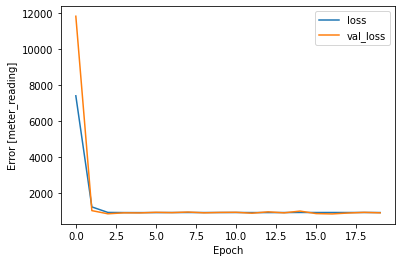

In [198]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [183]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

24/24 [==============================] - 0s 1ms/step - loss: 2114.5249


2114.52490234375

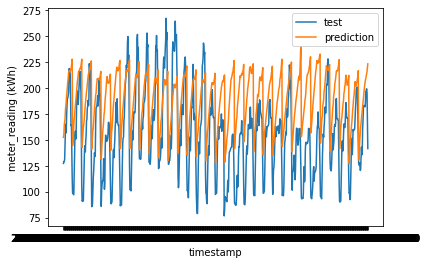

In [184]:
#range_min = np.min(test_features) - 10
#range_max = np.max(test_features) + 10
#x = tf.linspace(range_min, range_max, 200)
y = linear_regression_model.predict(test_features)
    
plt.plot(timestamp_test,test_labels, label = 'test')
plt.plot(timestamp_test,y, label = 'prediction')#*np.std(train_labels)+ np.mean(train_labels), label = 'prediction')
plt.ylabel('meter_reading (kWh)')
plt.xlabel('timestamp')
plt.legend()
plt.show()

In [122]:
learning_rates = np.array([0.01,0.02,0.05,0.08,0.1,0.15,0.2,0.3,0.4])
test_eval = np.zeros(learning_rates.shape)
num = 0

for lr in np.array([0.01,0.02,0.05,0.08,0.1,0.15,0.2,0.3,0.4]):
  linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])
  loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
  optim = keras.optimizers.Adam(lr=lr) #learning is super dependent on learning rate, for 0.01 it didn't learn well
  metrics=tf.keras.metrics.RootMeanSquaredError()

  linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

  history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=20,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)
  test_eval[num] = linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)
  num = num+1


Epoch 1/20
201/201 [==============================] - 1s 2ms/step - loss: 25140.1558 - val_loss: 26599.3359
Epoch 2/20
201/201 [==============================] - 0s 2ms/step - loss: 24651.5528 - val_loss: 26701.4258
Epoch 3/20
201/201 [==============================] - 0s 2ms/step - loss: 23508.6673 - val_loss: 26808.7832
Epoch 4/20
201/201 [==============================] - 0s 2ms/step - loss: 22757.6417 - val_loss: 26920.1270
Epoch 5/20
201/201 [==============================] - 0s 2ms/step - loss: 21924.6665 - val_loss: 27028.0527
Epoch 6/20
201/201 [==============================] - 0s 2ms/step - loss: 21115.0576 - val_loss: 27141.3516
Epoch 7/20
201/201 [==============================] - 0s 2ms/step - loss: 20414.9132 - val_loss: 27261.2832
Epoch 8/20
201/201 [==============================] - 0s 2ms/step - loss: 19496.0489 - val_loss: 27381.1211
Epoch 9/20
201/201 [==============================] - 0s 2ms/step - loss: 19037.6142 - val_loss: 27491.0430
Epoch 10/20
201/201 [=======

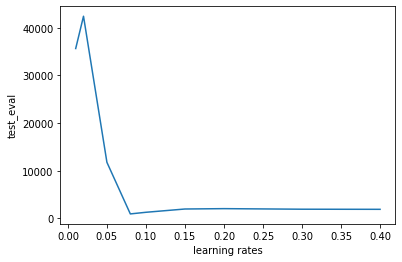

In [123]:
plt.plot(learning_rates, test_eval)
plt.xlabel('learning rates')
plt.ylabel('test_eval')
plt.show()

### 4. Let's do a training on all Educational buildings with all the features as described above:

In [199]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_educational_elect = pd_educational.loc[(pd_educational["meter"]==0)]
#pd_educational_elect = pd_educational_elect.loc[(pd_educational_elect["primary_use"]=='Education')]

### Make drop_ids (don't run this after first time, otherwise wait for 10min until this cell is done)

In [ ]:
drop_ids = []
for i in pd_educational_elect.building_id.unique():
  meter_reading_values = pd_educational_elect.loc[(pd_educational["building_id"]==i)]['meter_reading']
  meter_reading_values_diff = np.diff(meter_reading_values)
  if sum(meter_reading_values_diff==0) > 10:
    drop_ids.append(i)

In [ ]:
### Check how many building_ids have issues with meter_reading data:
print(len(drop_ids))
print(len(pd_educational_elect.building_id.unique()))
np.savetxt('dropids.txt', drop_ids)

1179
1413


### Load drop_ids generated before:

In [200]:
drop_ids = np.loadtxt('dropids.txt')

In [201]:
pd_educational_elect_clean = pd_educational_elect[~pd_educational_elect.building_id.isin(drop_ids)]
choose_bld_ids = pd_educational_elect_clean.building_id.unique()
pd_educational_10build = pd_educational_elect_clean[pd_educational_elect_clean.building_id.isin(choose_bld_ids)]

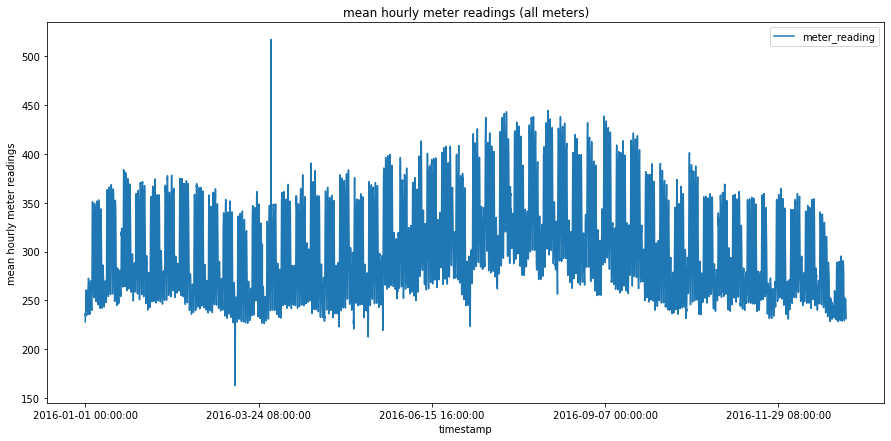

In [202]:
pd_educational_10build.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [203]:
#### Split time into month, weekday, hour and am/pm:
pd_educational_10build['month'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.month
pd_educational_10build['weekday'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.weekday
pd_educational_10build['hour'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.hour

In [204]:
pd_train_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) > datetime.datetime(2016, 11, 30)]

In [205]:
timestamp_train = pd_train_educ.pop('timestamp')
timestamp_test = pd_test_educ.pop('timestamp')

In [206]:
## New try on the dataset:
features = ['meter_reading','square_feet','year_built','air_temperature','month','weekday','hour']
pd_train_subset_educ = pd_train_educ[features]
train_features_educ = pd_train_subset_educ.copy()
pd_test_subset_educ = pd_test_educ[features]
test_features_educ = pd_test_subset_educ.copy()

train_labels_educ = train_features_educ.pop('meter_reading')
test_labels_educ = test_features_educ.pop('meter_reading')

In [207]:
#train_labels_norm_educ =(train_labels_educ - np.mean(train_labels_educ))/np.std(train_labels_educ)
#test_labels_norm_educ = (test_labels_educ - np.mean(train_labels_educ))/np.std(train_labels_educ) #normalize by train mean and std

## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features_educ))
print(normalizer.mean.numpy())

[1.4893533e+05 1.9695244e+03 1.5745275e+01 6.0817471e+00 3.0004725e+00
 1.1510880e+01]


In [208]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

linear_regression_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_14 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [210]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=1) # lr = 0.01
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [211]:
history = linear_regression_model.fit(
    train_features_educ, train_labels_educ,
    epochs=5,
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/5
50066/50066 [==============================] - 73s 1ms/step - loss: 107933.8254 - val_loss: 41316.1953
Epoch 2/5
50066/50066 [==============================] - 73s 1ms/step - loss: 99349.9826 - val_loss: 41304.7188
Epoch 3/5
50066/50066 [==============================] - 73s 1ms/step - loss: 99898.9512 - val_loss: 41855.9453
Epoch 4/5
50066/50066 [==============================] - 73s 1ms/step - loss: 99750.2401 - val_loss: 42993.9531
Epoch 5/5
50066/50066 [==============================] - 73s 1ms/step - loss: 100789.6908 - val_loss: 40003.9727


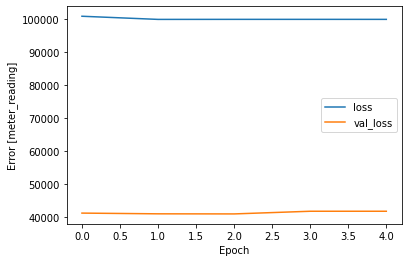

In [137]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [138]:
linear_regression_model.evaluate(
    test_features_educ,
    test_labels_educ, verbose=1)

5359/5359 [==============================] - 5s 1ms/step - loss: 68736.3047


68736.3046875

In [139]:
test_features_educ_all = test_features_educ.copy()
test_features_educ_all['timestamp'] = timestamp_test.copy()
test_features_educ_all['meter_reading']  = test_labels_educ

y = linear_regression_model.predict(test_features_educ)
y_norm= pd.DataFrame(y, columns = ['prediction'])


y_norm['timestamp'] = np.array(timestamp_test)
#test_features_educ_all.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot()
#y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).plot()

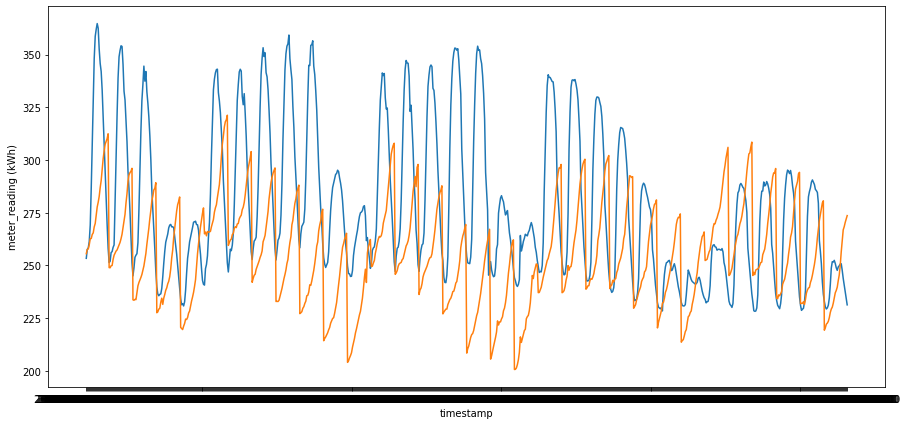

In [140]:
from matplotlib.pyplot import figure
figure(figsize =(15,7))
plt.plot(test_features_educ_all.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]))
plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]))
plt.xlabel('timestamp')
plt.ylabel('meter_reading (kWh)')
plt.show()

### 5. Let's try training on larger number of buildings but let's do one-hot encoding for primary_use houses:

In [288]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_educational_elect = pd_educational.loc[(pd_educational["meter"]==0)]
#pd_educational_elect = pd_educational_elect.loc[(pd_educational_elect["primary_use"]=='Education')]

In [289]:
drop_ids = np.loadtxt('dropids.txt')

In [290]:
pd_educational_elect_clean = pd_educational_elect[~pd_educational_elect.building_id.isin(drop_ids)]
choose_bld_ids = pd_educational_elect_clean.building_id.unique()
pd_educational_10build = pd_educational_elect_clean[pd_educational_elect_clean.building_id.isin(choose_bld_ids)]

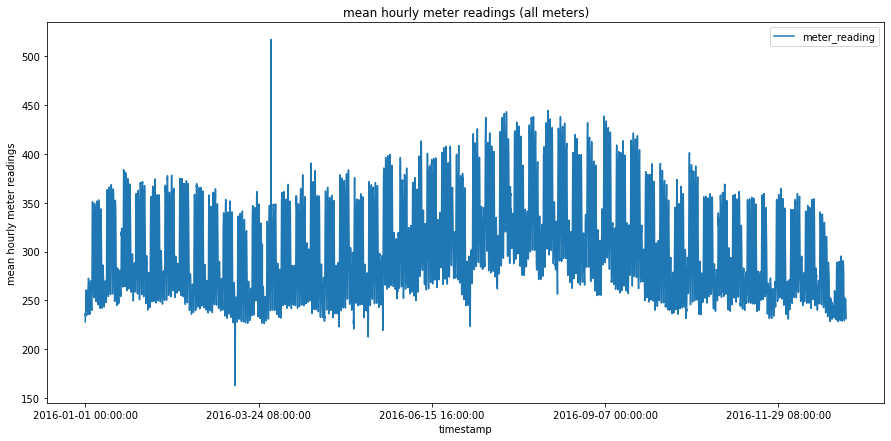

In [291]:
pd_educational_10build.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [292]:
#### Split time into month, weekday, hour and am/pm:
pd_educational_10build['month'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.month
pd_educational_10build['weekday'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.weekday
pd_educational_10build['hour'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.hour

In [293]:
pd_train_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) > datetime.datetime(2016, 11, 30)]

In [294]:
timestamp_train = pd_train_educ.pop('timestamp')
timestamp_test = pd_test_educ.pop('timestamp')

## New try on the dataset:
features = ['meter_reading','primary_use','square_feet','year_built','air_temperature','month','weekday','hour']
pd_train_subset_educ = pd_train_educ[features]
train_features_educ = pd_train_subset_educ.copy()
pd_test_subset_educ = pd_test_educ[features]
test_features_educ = pd_test_subset_educ.copy()

train_labels_educ = train_features_educ.pop('meter_reading')
test_labels_educ = test_features_educ.pop('meter_reading')

In [295]:
# Let's transform primary_use from string into numerical:
print(train_features_educ.primary_use.unique())

from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
train_prim_use_ecod = le.fit_transform(train_features_educ.primary_use)
np.unique(train_prim_use_ecod)
train_features_educ['primary_use'] = train_prim_use_ecod

['Public services' 'Office' 'Education' 'Lodging/residential'
 'Food sales and service' 'Entertainment/public assembly'
 'Warehouse/storage' 'Other' 'Healthcare' 'Utility' 'Parking'
 'Technology/science' 'Retail' 'Manufacturing/industrial']


In [303]:
train_features_educ['primary_use'].values

array([9, 9, 9, ..., 9, 9, 9])

In [306]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

def do_feature_encoding(train, test): 
	# initialize the column names of the continuous data
  numeric = ["square_feet", "year_built", "air_temperature", 'month','weekday','hour']
	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
  cs = MinMaxScaler()
  trainContinuous = cs.fit_transform(train[numeric])
  testContinuous = cs.transform(test[numeric])
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	#zipBinarizer = LabelBinarizer().fit(df["zipcode"])
  one_hot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoder.fit(train["primary_use"])
  trainCathegorical = lb.transform(train["primary_use"])
  testCategorical = lb.transform(test["primary_use"])
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
  trainX = np.hstack([trainCategorical, trainContinuous])
  testX = np.hstack([testCategorical, testContinuous])
	# return the concatenated training and testing data
  return (trainX, testX)

In [307]:
trainX, testY = do_feature_encoding(train_features_educ, test_features_educ)

ValueError: ignored